In [1]:
import torch
from torch import nn
from utils_torch import * 
import utils_torch as ut

# LSTM

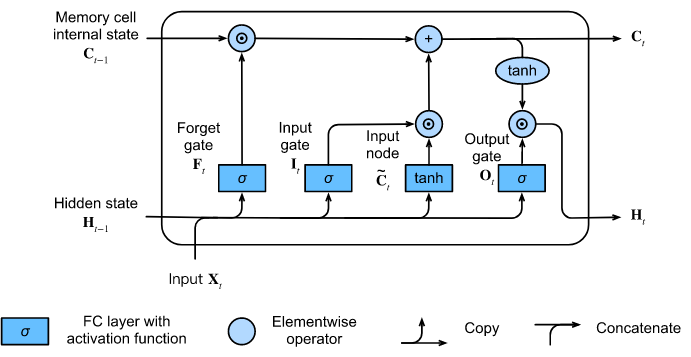 

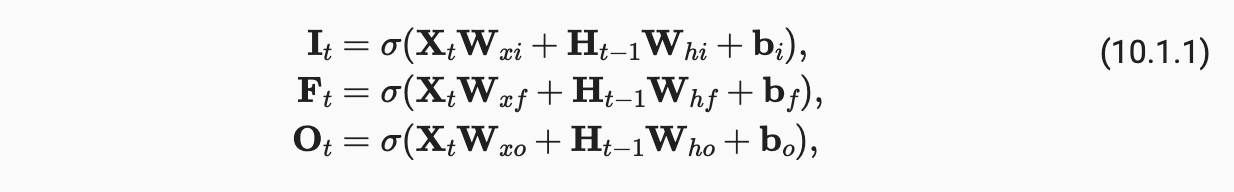
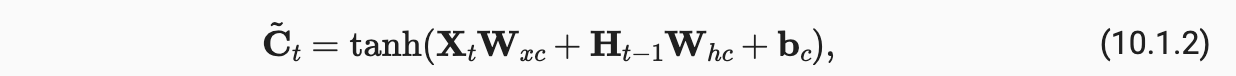
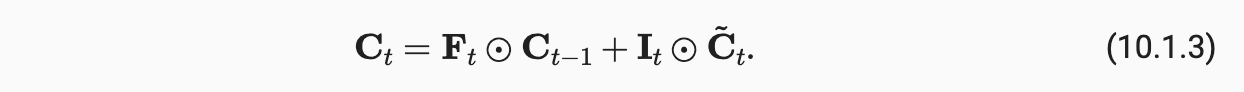
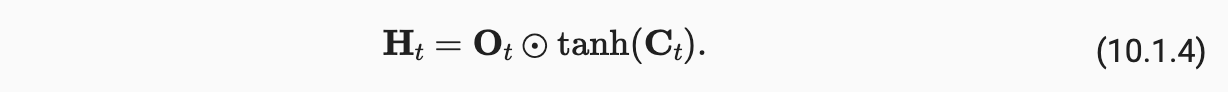

## Implementation from Scratch

In [2]:
class LSTM(Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (
            init_weight(num_inputs,num_hiddens),
            init_weight(num_hiddens,num_hiddens),
            nn.Parameter(torch.zeros(num_hiddens))
        )
        
        self.W_xi, self.W_hi, self.b_i = triple() # Input gate
        self.W_xf, self.W_hf, self.b_f = triple() # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple() # Output gate
        self.W_xc, self.W_hc, self.b_c = triple() # Input node
        
    def forward(self, X, H_C=None):
        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((X.shape[1], self.num_hiddens), device=X.device)
            C = torch.zeros((X.shape[1], self.num_hiddens), device=X.device)
        else: 
            H, C = H_C
        
        outputs = []
        for x in X:
            I = torch.sigmoid(torch.matmul(x, self.W_xi) + torch.matmul(H, self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.matmul(x, self.W_xf) + torch.matmul(H, self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.matmul(x, self.W_xo) + torch.matmul(H, self.W_ho) + self.b_o)
            C_tilde = torch.tanh(torch.matmul(x, self.W_xc) + torch.matmul(H, self.W_hc) + self.b_c)
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H)
        return outputs, (H, C)       
        

### Trainig

In [3]:
data = ut.TimeMachine(batch_size=1024, num_steps=100)
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = ut.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=0.01)
trainer = ut.Trainer(max_epochs=10, gradient_clip_val=1, number_of_gpus=0)


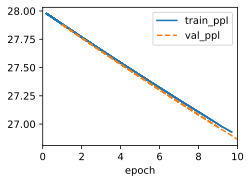

In [4]:
trainer.fit(model, data)

## Concise Implementation

In [11]:
class LSTMTorch(Module):
    def __init__(self, num_inputs,num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)
        
    def forward(self, X, H_C=None):
        return self.rnn(X, H_C)
    

In [14]:
class RNNLM(RNNLMScratch):
    """The RNN-based language model implemented with high-level APIs.
    Defined in :numref:`sec_rnn-concise`"""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return swapaxes(self.linear(hiddens), 0, 1)


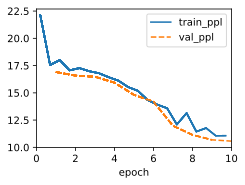

In [15]:
lstm = LSTMTorch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [16]:
model.predict('it has', 20, data.vocab, try_gpu())

'it has an the the the the '

# Gated Recurrent Units (GRU)¶
